In [2]:
import numpy as np
import cuml
import cudf, cupy
import sklearn
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [12]:
X_train, y_train, X_test = np.load("./data/dataset.npz", allow_pickle=True).values()
print(X_train.shape, y_train.shape, X_test.shape)

Xg_train = cudf.DataFrame(X_train)
yg_train = cudf.Series(y_train)
Xg_test = cudf.DataFrame(X_test)

N_ = np.logspace(2, 5, 6).astype(int)

N_full = X_train.shape[0]

N_ = np.append(N_, N_full)
print(N_)

(524164, 9) (524164,) (174722, 9)
[   100    398   1584   6309  25118 100000 524164]


In [13]:
import time

times = []
for size in N_:
    start = time.time()
    clf = RandomForestRegressor(random_state=42, n_jobs=-1)
    clf.fit(X_train[:size], y_train[:size])
    print(f"Trained on {size} samples in {time.time() - start:.2f} seconds")
    times.append(time.time() - start)


Trained on 100 samples in 0.12 seconds
Trained on 398 samples in 0.15 seconds
Trained on 1584 samples in 0.24 seconds
Trained on 6309 samples in 0.79 seconds
Trained on 25118 samples in 3.69 seconds
Trained on 100000 samples in 20.84 seconds
Trained on 524164 samples in 211.64 seconds


In [14]:
gpu_times = []
for size in N_:
    start = time.time()
    clf = cuml.ensemble.RandomForestRegressor(random_state=42)
    clf.fit(Xg_train[:size], yg_train[:size])
    print(f"Trained on {size} samples in {time.time() - start:.2f} seconds")
    gpu_times.append(time.time() - start)

/home/ahackl/.local/lib/python3.13/site-packages/cuml/internals/api_decorators.py:211: UserWarning: The number of bins, `n_bins` is greater than the number of samples used for training. Changing `n_bins` to number of training samples.
  ret = func(*args, **kwargs)


Trained on 100 samples in 0.62 seconds
Trained on 398 samples in 0.23 seconds
Trained on 1584 samples in 0.32 seconds
Trained on 6309 samples in 0.44 seconds
Trained on 25118 samples in 0.75 seconds
Trained on 100000 samples in 1.70 seconds
Trained on 524164 samples in 8.74 seconds


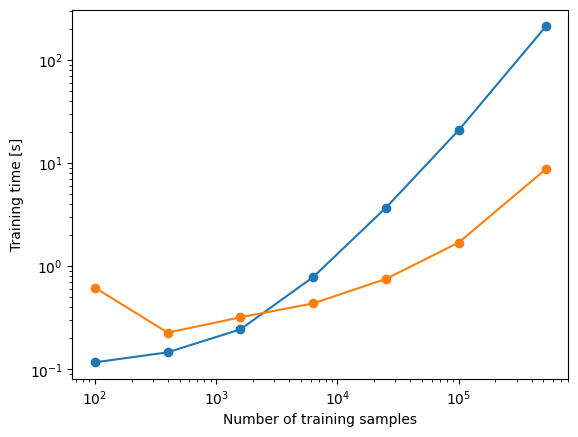

In [15]:
fig, ax = plt.subplots()
ax.plot(N_, times, marker='o')
ax.plot(N_, gpu_times, marker='o')
ax.set_xlabel("Number of training samples")
ax.set_ylabel("Training time [s]")
ax.set_xscale("log")
ax.set_yscale("log")


In [16]:
clf = cuml.ensemble.RandomForestRegressor(random_state=42)
clf.fit(Xg_train, yg_train)

RandomForestRegressor()

In [17]:
y_pred =clf.predict(X_test)

In [18]:
import pandas
dtest = pandas.read_csv('./data/test.csv')

dl = pandas.DataFrame({'id': dtest['id'], 'beats': y_pred})
dl.to_csv('./data/submission_rf.csv', index=False)